In [4]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128
Receiving objects: 100% (131/131), 1.13 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [5]:
%cd stylegan2-ada-pytorch/
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

/content/stylegan2-ada-pytorch
--2023-12-17 16:57:41--  https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 18.244.202.50, 18.244.202.77, 18.244.202.81, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|18.244.202.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381624121 (364M) [binary/octet-stream]
Saving to: ‘ffhq.pkl’

ffhq.pkl            100%[===================>] 363.94M  32.0MB/s    in 12s     

2023-12-17 16:57:54 (30.9 MB/s) - ‘ffhq.pkl’ saved [381624121/381624121]



In [2]:
import torch, pickle
import functools

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import PCA

In [6]:
# Retrieving Generator
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

with open('ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].to(device)  # torch.nn.Module
if device_name == "cpu":
  G.synthesis.forward = functools.partial(G.synthesis.forward, force_fp32=True)
z = torch.randn([1, G.z_dim]).to(device)    # latent codes
c = None                                # class labels (not used in this example)

# Creating an image
img = G(z, c)                           # NCHW, float32, dynamic range [-1, +1]

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


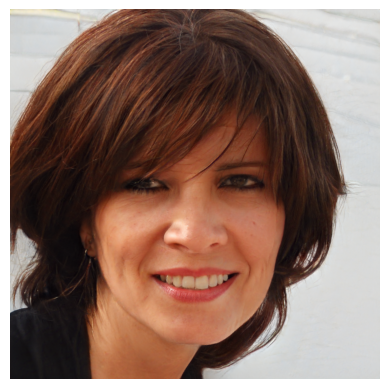

In [7]:
# Plotting the image
image = 0.5*(img[0]+1).cpu().detach().numpy()

plt.imshow(image.transpose(1, 2, 0))
plt.axis('off')
plt.show()

#GanSpace

In [8]:
def W_PCA(G, N):
  """
  PCA on W space.

  G : Generator from StyleGAN2
  N : sample size for PCA
  """
  d = G.z_dim
  Z = torch.randn([N, d]).to(device)
  W = G.mapping(Z, None)
  W_pca = W[:, 0, :].cpu().detach().numpy() # We slice one of the 18 equam styles as we just want to do a PCA.
  pca = PCA()
  pca.fit(W_pca)
  V = torch.tensor(pca.components_).to(device)
  Var = torch.tensor(pca.explained_variance_)

  # Rescaling of each vectors from the PCA by its eplained variance
  for vec, var in zip(V, Var) :
    vec *= np.sqrt(var)

  return V

In [9]:
def AllLayers(V, G, n_components = 6, n_steps_var = 7, k=0, N_sigma=2.):

  """
  Create an image and apply some transformation to all the layers of the synthesis part of the
  StyleGAN2 architecture alog the first n_components

  k : REVOIR CETTE HISTOIRE DE CHOIX DES COMPONENTS
  k=0 will take the n_components first components, k=1 the n_components next etc.
  N_sigma : scale the power of the changes.

  """
  d = G.z_dim
  z = torch.randn((1, d), device=device)
  w = G.mapping(z, None)
  steps = torch.linspace(-1.0, 1.0, n_steps_var)*N_sigma

  fig = plt.figure(figsize=(2*n_steps_var, 2*n_components))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_components, n_steps_var), axes_pad=0.1)

  for icomp in range(n_components):
      for istep in range(n_steps_var):
          w_transformed = w.clone()#.to(device)
          w_transformed += steps[istep]*V[k*n_components + icomp]

          #w_transformed = torch.tensor(w_transformed, device=device)
          img = G.synthesis(w_transformed).cpu().detach().numpy()[0].transpose((1,2,0))
          img = (img+1)/2
          iplot = icomp*n_steps_var + istep
          grid[iplot].imshow(img)

          if istep==0 :
            grid[iplot].set_ylabel(f"Component {k*n_components + icomp+1}", rotation = 0, size = 'large')

          grid[iplot].imshow(img)
          grid[iplot].set_yticklabels([])
          grid[iplot].set_xticklabels([])
          grid[iplot].set_xticks([])
          grid[iplot].set_yticks([])

  plt.show()

In [10]:
N = 100_000
V = W_PCA(G, N)

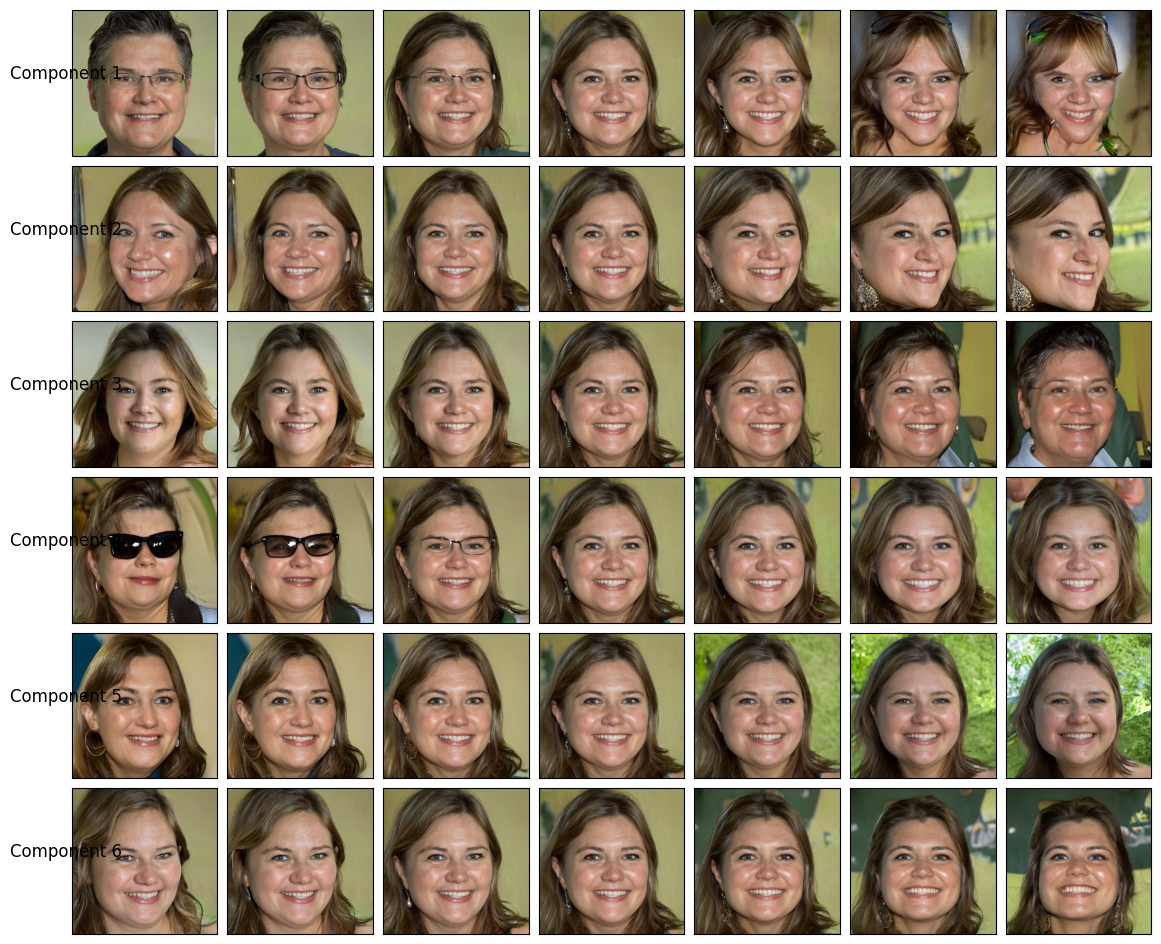

In [12]:
AllLayers(V, G)

In [18]:
def LayerWise(V, G, comp = 0, layer_groups = None, n_steps_var = 7, k=0, N_sigma=2.):
  """
  Do a layer-wise change along the vector number "comp" of the V basis from PCA.

  k=0 will take the n_components_plot first components, k=1 the n_components_plot next etc.
  layer_groups : Default corresponds to groups of Figure 3 of StyleGAN paper (2019)
  i.e. Core styles (layers 1-4); Middle styles (5-9); Fine styles (10-18)
  """
  d = G.z_dim
  if layer_groups is None :
    layer_groups = [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]

  n_plot = len(layer_groups)

  z = torch.randn((1, d), device=device)
  w = G.mapping(z, None)

  steps = torch.linspace(-1.0, 1.0, n_steps_var)*N_sigma

  fig = plt.figure(figsize=(4*n_steps_var, 4*n_plot))
  grid = ImageGrid(fig, 111, nrows_ncols=(n_plot, n_steps_var), axes_pad=0.1)

  for i, group in enumerate(layer_groups):
    for istep in range(n_steps_var):
        w_transformed = w.clone()
        w_transformed[:, group, :] += steps[istep] * V[comp]

        w_transformed = torch.tensor(w_transformed, device=device)
        img = G.synthesis(w_transformed).cpu().detach().numpy()[0].transpose((1, 2, 0))
        img = (img + 1) / 2
        iplot = i * n_steps_var + istep

        if istep==0 :
          grid[iplot].set_ylabel(f"Group {i+1}", rotation = 0, size = 'large')

        grid[iplot].imshow(img)
        grid[iplot].set_yticklabels([])
        grid[iplot].set_xticklabels([])
        grid[iplot].set_xticks([])
        grid[iplot].set_yticks([])

plt.show()

<ipython-input-18-749269252084>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_transformed = torch.tensor(w_transformed, device=device)
<ipython-input-18-749269252084>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_transformed = torch.tensor(w_transformed, device=device)
<ipython-input-18-749269252084>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_transformed = torch.tensor(w_transformed, device=device)
<ipython-input-18-749269252084>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.c

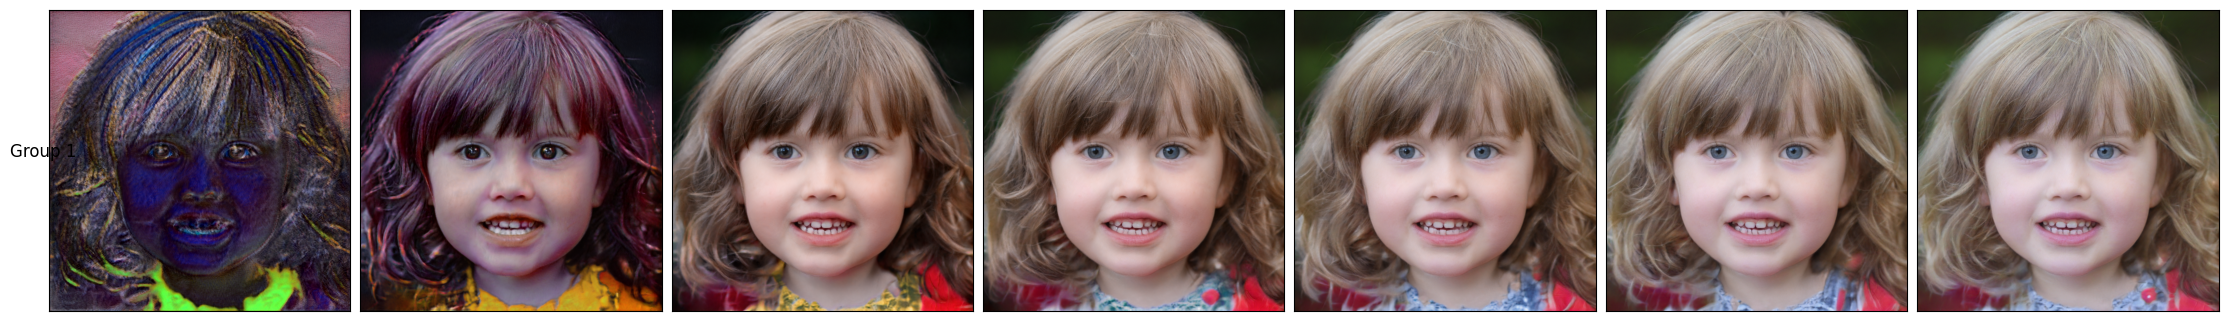

In [19]:
LayerWise(V, G, 9, layer_groups=[[13,15]], N_sigma=15)